In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from scipy import stats as st
from palettable.tableau import Tableau_10

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42239,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:39453,Total threads: 4
Dashboard: /proxy/33871/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:46843,


In [13]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [2]:
uas = {}
psl = {}
uas['cmip6'] = xr.concat([xr.open_dataset('../data/uas-monthly-1979_2015-cmip6.nc').sel(time = slice('1979-01-01', '2015-01-01'))['uas'], \
                          xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc').sel(time = slice('2015-01-01', '2100-01-01'))['uas']], \
                          dim = 'time')
psl['cmip6'] = xr.concat([xr.open_dataset('../data/psl-monthly-1979_2015-cmip6.nc').sel(time = slice('1979-01-01', '2015-01-01'))['psl'], \
                          xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc').sel(time = slice('2015-01-01', '2100-01-01'))['psl']], \
                          dim = 'time')

In [16]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['cmip6']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['cmip6'].isel(time = 0)))
for i in range(len(uas['cmip6']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['cmip6']['lat'], 'lon':uas['cmip6']['lon']})

In [8]:
path_uas = np.sort(glob.glob('../data/cmip6-regridded/uas_hist*'))
path_psl = np.sort(glob.glob('../data/cmip6-regridded/psl_hist*'))
path_uas_p = np.sort(glob.glob('../data/cmip6-regridded/uas_ssp*'))
path_psl_p = np.sort(glob.glob('../data/cmip6-regridded/psl_ssp*'))

In [10]:
uas_cmip = {}; psl_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas[model_name] = xr.concat([xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas'], \
                                 xr.open_dataset(path_uas_p[i]).sel(time = slice('2015-01-01', '2100-01-01'))['uas']], \
                                 dim = 'time')
    
    psl[model_name] = xr.concat([xr.open_dataset(path_psl[i]).sel(time = slice('1979-01-01', '2015-01-01'))['psl'], \
                                 xr.open_dataset(path_psl_p[i]).sel(time = slice('2015-01-01', '2100-01-01'))['psl']], \
                                 dim = 'time')
model_keys = list(uas.keys())

In [25]:
for k in model_keys[1:]:
    uas[k]['time'] = uas['cmip6']['time'].values
    psl[k]['time'] = psl['cmip6']['time'].values

In [26]:
# Convert to xarray
uas_xarray = (uas['cmip6'].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
kat_idx = (psl['cmip6'].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
           psl['cmip6'].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')
sam_idx = (psl['cmip6'].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
           psl['cmip6'].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')
for k in model_keys[1:]:
    uas_xarray = xr.concat([uas_xarray, 
                            (uas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))], 
                            dim = 'model')
                            
    kat_idx = xr.concat([kat_idx, 
                         (psl[k].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
                         psl[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')], 
                         dim = 'model')
    
    sam_idx = xr.concat([sam_idx, 
                         (psl[k].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
                         psl[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')], 
                         dim = 'model')

In [28]:
uas_xarray['model'] = model_keys
kat_idx['model'] = model_keys
sam_idx['model'] = model_keys

In [29]:
uas_sd = uas_xarray.drop_sel(model = 'cmip6').std('model')
kat_sd = kat_idx.drop_sel(model = 'cmip6').std('model')
sam_sd = sam_idx.drop_sel(model = 'cmip6').std('model')

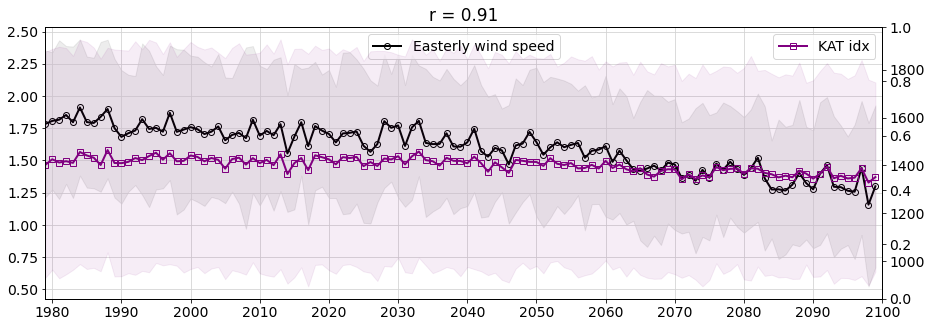

In [45]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot()
ax1.grid(linestyle = '-', color = 'lightgrey')
ax1.set_xticks(np.arange(1980, 2110, 10))
ax1.set_xticklabels(np.arange(1980, 2110, 10))
ax1.set_xlim(1979, 2100)
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(uas_xarray.sel(model = 'cmip6')['year'], -uas_xarray.sel(model = 'cmip6'), color = 'k', marker = 'o', markerfacecolor = 'none', 
         linewidth = 2, label = 'Easterly wind speed')
ax1.fill_between(uas_xarray.sel(model = 'cmip6')['year'], -uas_xarray.sel(model = 'cmip6')+uas_sd, -uas_xarray.sel(model = 'cmip6')-uas_sd,
                 color = 'k', alpha = 0.07)
ax2.plot(kat_idx.sel(model = 'cmip6')['year'], kat_idx.sel(model = 'cmip6'), color = 'purple', marker = 's', markerfacecolor = 'none', 
         linewidth = 2, label = 'KAT idx')
ax2.fill_between(kat_idx.sel(model = 'cmip6')['year'], kat_idx.sel(model = 'cmip6')-kat_sd, kat_idx.sel(model = 'cmip6')+kat_sd,
                 color = 'purple', alpha = 0.07)

ax1.legend(loc = 'upper center')
ax2.legend(loc = 'upper right')
plt.title('r = 0.91')
plt.savefig('../results/v5/uas-kat-projection.jpg', bbox_inches = 'tight')

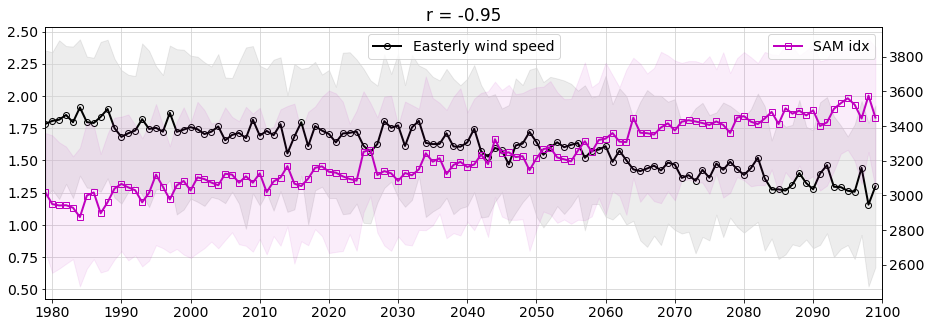

In [44]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot()
ax1.grid(linestyle = '-', color = 'lightgrey')
ax1.set_xticks(np.arange(1980, 2110, 10))
ax1.set_xticklabels(np.arange(1980, 2110, 10))
ax1.set_xlim(1979, 2100)
ax3 = ax1.twinx()

ax1.plot(uas_xarray.sel(model = 'cmip6')['year'], -uas_xarray.sel(model = 'cmip6'), color = 'k', marker = 'o', markerfacecolor = 'none', 
         linewidth = 2, label = 'Easterly wind speed')
ax1.fill_between(uas_xarray.sel(model = 'cmip6')['year'], -uas_xarray.sel(model = 'cmip6')+uas_sd, -uas_xarray.sel(model = 'cmip6')-uas_sd,
                 color = 'k', alpha = 0.07)
ax3.plot(sam_idx.sel(model = 'cmip6')['year'], sam_idx.sel(model = 'cmip6'), color = 'm', marker = 's', markerfacecolor = 'none', 
         linewidth = 2, label = 'SAM idx')
ax3.fill_between(sam_idx.sel(model = 'cmip6')['year'], sam_idx.sel(model = 'cmip6')-sam_sd, sam_idx.sel(model = 'cmip6')+sam_sd,
                 color = 'm', alpha = 0.07)

ax1.legend(loc = 'upper center')
ax3.legend(loc = 'upper right')
plt.title('r = -0.95')
plt.savefig('../results/v5/uas-sam-projection.jpg', bbox_inches = 'tight')

In [36]:
st.linregress(kat_idx.sel(model = 'cmip6'), -uas_xarray.sel(model = 'cmip6'))

LinregressResult(slope=0.0051201682246857895, intercept=-5.582075913789707, rvalue=0.9081883476722311, pvalue=7.82892657816787e-47, stderr=0.0002163188400017466, intercept_stderr=0.3033662876323871)

In [37]:
st.linregress(sam_idx.sel(model = 'cmip6'), -uas_xarray.sel(model = 'cmip6'))

LinregressResult(slope=-0.0009429688729077297, intercept=4.634723563465771, rvalue=-0.946888276995354, pvalue=1.7830438675467062e-60, stderr=2.9355592265807933e-05, intercept_stderr=0.09470855116226717)

# SLP field

In [54]:
psl_change = psl['cmip6'].sel(time = slice('2080-01-01', None)).mean('time') - \
             psl['cmip6'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')

In [77]:
import matplotlib.path as mpath

In [78]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

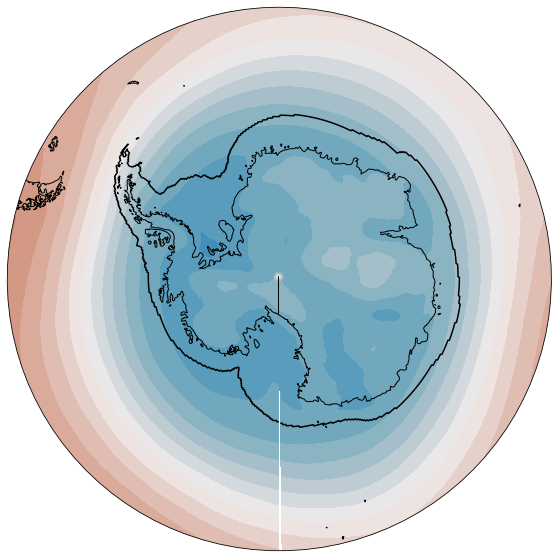

In [99]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'k', facecolor = 'none'), zorder = 1)
ax.spines['geo']
ax.patch.set_alpha(0)
ax.set_boundary(circle, transform = ax.transAxes)

ax.contourf(psl_change['lon'], psl_change['lat'], psl_change/100, levels = np.arange(-8, 8.5, .5), cmap = cmocean.cm.balance,
            extend = 'both', transform = ccrs.PlateCarree(), zorder = 0)
ax.plot(div_line[0], div_line[1], color = 'k', transform = ccrs.PlateCarree())